In [6]:
# Import necessary packages
import pandas as pd
import numpy as np
import re
from collections import defaultdict

# Processo ETL para Dados de Custos dos Tanques de Tilápia

Este documento descreve o processo de **ETL (Extração, Transformação e Carga)** aplicado aos dados de custos por tanque de tilápia, extraídos de uma planilha financeira do Excel.

## 📄 Objetivo

Extrair variáveis específicas de custo (ex: `Compra Alev`, `Compra Raç`, `Condomínio`, etc.) organizadas por tanque, padronizando os nomes das variáveis e formatando os dados em uma estrutura comparável entre os tanques.

---

## 🔍 Etapas do Processo

### 1. **Extração**

- Carrega o arquivo Excel: `DELICIOUS FISH 2024 - V128 - TILÁPIAS FÁBIO (2).xlsx`
- Lê a aba: `"Centros de custo 2024"`
- Identifica a coluna `"TOTAL"` contendo os valores consolidados de cada variável por tanque.

### 2. **Transformação**

- Percorre as linhas do arquivo, detectando o início de cada **bloco de tanque** por expressões como `"TILÁPIA SETOR 1 TANQUE 01"`.
- Extrai o nome da variável e o valor correspondente, removendo sufixos como `"TANQUE 01"` para padronizar os nomes (ex: `"COMPRA ALEV TANQUE 01"` se torna `"Compra Alev"`).
- Reorganiza os dados em **formato largo**, onde:
  - Cada linha representa um **tanque** (`Tanque 01`, `Tanque 02`, etc.)
  - Cada coluna representa uma **variável padronizada**
- Garante que os tanques estejam ordenados numericamente (ex: `Tanque 01` antes de `Tanque 02`).

### 3. **Carga**

- Gera um `DataFrame` com os dados organizados.
- Exporta os resultados em um arquivo Excel: `custos_por_tanque_normalizados.xlsx`

---

## ✅ Benefícios

- Nomes de variáveis padronizados e prontos para análise
- Estrutura organizada para **relatórios, dashboards e análises preditivas**
- Fácil de aplicar para novos períodos ou novos tanques

---


In [ ]:
# Recarregar os dados da planilha inteira
file_path = 'DELICIOUS_FISH.xlsx'
sheet_name='Centros de custo 2024'
df_raw = pd.read_excel(file_path, sheet_name=sheet_name)

# ✅ Definir a coluna do total corretamente
total_col = df_raw.columns[-1]

# Redefinir containers
tank_data = {}
current_tank_label = None

# Identificar manualmente o cabeçalho do primeiro tanque se estiver no topo
first_row_label = str(df_raw.columns[0])
if "TILÁPIA SETOR" in first_row_label and "TANQUE" in first_row_label:
    match = re.search(r'TANQUE\s+(\d+)', first_row_label, re.IGNORECASE)
    if match:
        tank_number = match.group(1).zfill(2)
        current_tank_label = f"Tanque {tank_number}"
        tank_data[current_tank_label] = {}

# Iterar linha por linha da planilha
for _, row in df_raw.iterrows():
    first_cell = str(row.iloc[0]) if pd.notna(row.iloc[0]) else ""

    # Detecta novo tanque se aparecer
    if "TILÁPIA SETOR" in first_cell and "TANQUE" in first_cell:
        match = re.search(r'TANQUE\s+(\d+)', first_cell, re.IGNORECASE)
        if match:
            tank_number = match.group(1).zfill(2)
            current_tank_label = f"Tanque {tank_number}"
            tank_data[current_tank_label] = {}

    # Coleta dados de variáveis
    if current_tank_label:
        var_name = row.iloc[3] if len(row) > 3 else None
        if pd.notna(var_name):
            total_value = row[total_col]
            if pd.notna(total_value) and isinstance(total_value, (int, float, np.number)):
                clean_var = re.sub(r'TANQUE \d+', '', var_name, flags=re.IGNORECASE).strip()
                tank_data[current_tank_label][clean_var] = total_value

# Confirmar se o Tanque 01 foi incluído
tank_data_keys = list(tank_data.keys())
tank_data_keys


['Tanque 01',
 'Tanque 02',
 'Tanque 03',
 'Tanque 04',
 'Tanque 05',
 'Tanque 06',
 'Tanque 07',
 'Tanque 08',
 'Tanque 09',
 'Tanque 10',
 'Tanque 11',
 'Tanque 12',
 'Tanque 13',
 'Tanque 14',
 'Tanque 15',
 'Tanque 16',
 'Tanque 17',
 'Tanque 18',
 'Tanque 19']

In [9]:
# Converter para DataFrame e normalizar as variáveis como antes
df_wide = pd.DataFrame.from_dict(tank_data, orient='index').reset_index()
df_wide = df_wide.rename(columns={'index': 'Tanque'})

# Normalização dos nomes das variáveis
variable_map = defaultdict(list)
for col in df_wide.columns[1:]:
    base_name = re.sub(r'TANQUE \d+', '', col, flags=re.IGNORECASE).strip()
    variable_map[base_name].append(col)

df_normalized = pd.DataFrame()
df_normalized['Tanque'] = df_wide['Tanque']
for base_var, cols in variable_map.items():
    df_normalized[base_var] = df_wide[cols].sum(axis=1, skipna=True)


In [10]:
# Ordenação correta
df_normalized['Tanque_Num'] = df_normalized['Tanque'].str.extract(r'(\d+)').astype(int)
df_normalized = df_normalized.sort_values(by='Tanque_Num').drop(columns='Tanque_Num').reset_index(drop=True)

# Exportar para novo arquivo Excel
output_path = "custos_por_tanque.xlsx"
df_normalized.to_excel(output_path, index=False)

output_path

'custos_por_tanque.xlsx'

##################

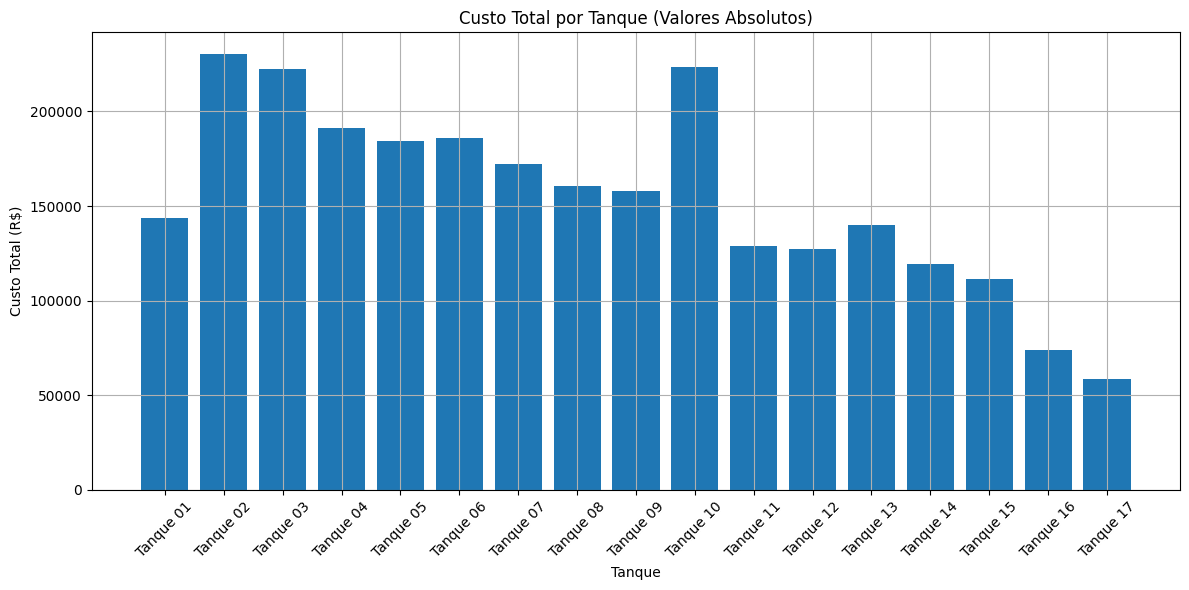

In [ ]:
import matplotlib.pyplot as plt

# Criar uma cópia do df para análise
df_filtered = df_normalized[~df_normalized['Tanque'].isin(['Tanque 18', 'Tanque 19'])].copy()

# Separar os grupos
grupo_receita = df_filtered[df_filtered["VENDA PX ABAT"] > 0].copy()
grupo_sem_receita = df_filtered[df_filtered["VENDA PX ABAT"] == 0].copy()

# Calcular custo total (soma de todas variáveis de custo)
# Vamos considerar todas colunas numéricas, exceto 'VENDA PX ABAT' como custos
colunas_custo = [col for col in df_filtered.columns if col not in ['Tanque', 'VENDA PX ABAT']]

df_filtered["CUSTO TOTAL"] = df_filtered[colunas_custo].sum(axis=1, skipna=True)
# Gráfico corrigido: Custo Total por Tanque (com valores absolutos)
df_filtered["CUSTO TOTAL ABS"] = df_filtered["CUSTO TOTAL"].abs()

plt.figure(figsize=(12, 6))
plt.bar(df_filtered["Tanque"], df_filtered["CUSTO TOTAL ABS"])
plt.title("Custo Total por Tanque (Valores Absolutos)")
plt.xlabel("Tanque")
plt.ylabel("Custo Total (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

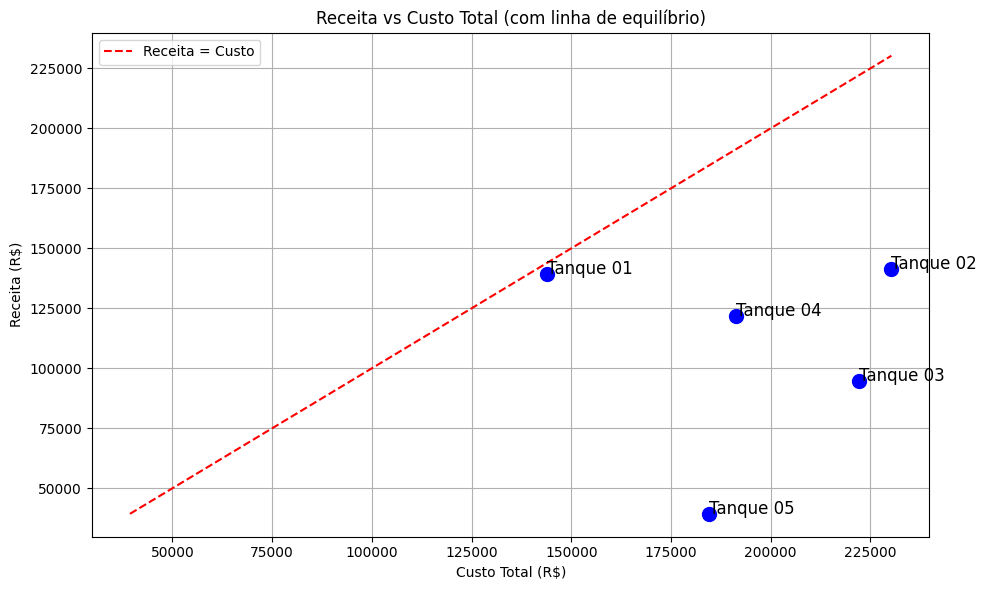

In [ ]:
# Recalcular custo total absoluto para o grupo com receita
grupo_receita["CUSTO TOTAL"] = grupo_receita[colunas_custo].sum(axis=1, skipna=True).abs()

# Gráfico de dispersão com linha diagonal
plt.figure(figsize=(10, 6))
plt.scatter(grupo_receita["CUSTO TOTAL"], grupo_receita["VENDA PX ABAT"], s=100, color='blue')

# Adicionar linha diagonal (linha de break-even)
min_val = min(grupo_receita["CUSTO TOTAL"].min(), grupo_receita["VENDA PX ABAT"].min())
max_val = max(grupo_receita["CUSTO TOTAL"].max(), grupo_receita["VENDA PX ABAT"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Receita = Custo')

# Adicionar rótulos dos tanques
for i, row in grupo_receita.iterrows():
    plt.text(row["CUSTO TOTAL"], row["VENDA PX ABAT"], row["Tanque"], fontsize=12, ha='left')

plt.title("Receita vs Custo Total (com linha de equilíbrio)")
plt.xlabel("Custo Total (R$)")
plt.ylabel("Receita (R$)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()